# GPU vs CPU Benchmarking: CCC Coefficient Computation

This notebook benchmarks the GPU-accelerated CCC (Clustermatch Correlation Coefficient) implementation against the CPU version.

## Overview

The CCC coefficient measures relationships between features in high-dimensional data. This notebook:
- Runs configurable benchmarks comparing GPU (`ccc_gpu`) vs CPU (`ccc`) implementations
- Tests various data dimensions (n_features × n_samples)
- Validates numerical correctness (GPU results ≈ CPU results)
- Visualizes speedup gains from GPU acceleration

## Test Configuration

Benchmarks test random numerical data across different scales. For a dataset with F features and N samples:
- Input shape: (F, N)
- Output: F×(F-1)/2 pairwise correlation coefficients
- Computational complexity: O(F²×N)

## 1. Setup and Imports

In [21]:
# Standard library imports
import time
import warnings
from typing import Tuple, List, Dict, Any
from pathlib import Path

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# CCC implementations
from ccc.coef.impl_gpu import ccc as ccc_gpu
from ccc.coef.impl import ccc

# GPU memory management
try:
    import cupy as cp
    GPU_AVAILABLE = True
except ImportError:
    GPU_AVAILABLE = False
    warnings.warn("CuPy not available. GPU benchmarks will fail.")

# Styling
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ All imports successful")
print(f"✓ GPU Available: {GPU_AVAILABLE}")

✓ All imports successful
✓ GPU Available: True


## 2. Configuration

Modify these parameters to customize the benchmark suite.

In [22]:
# Benchmark configuration
CONFIG = {
    # Test cases: (n_features, n_samples)
    # Note: n_samples is fixed at 1000 for consistent comparison
    'test_cases': [
        # Small cases - quick validation
        (10, 100),
        (50, 500),
        
        # Standard benchmark cases (n_samples = 1000)
        (500, 1000),
        (1000, 1000),
        (2000, 1000),
        (4000, 1000),
        (6000, 1000),
        (8000, 1000),
        (10000, 1000),
        
        # Large cases - uncomment for stress testing
        (16000, 1000),
        (20000, 1000),
    ],
    
    # Random seed for reproducibility
    'seed': 42,
    
    # CPU core configurations to test (list of values)
    # Default: [6, 12, 24] to compare different parallelization levels
    'n_cpu_cores': [6, 12, 24],
    
    # Add singleton features (constant values)
    'contain_singletons': False,
    
    # Numerical tolerance for validation
    'rtol': 1e-6,
    'atol': 1e-6,
}

print("Configuration:")
print(f"  Test cases: {len(CONFIG['test_cases'])}")
print(f"  CPU core configurations: {CONFIG['n_cpu_cores']}")
print(f"  Total benchmarks: {len(CONFIG['test_cases']) * len(CONFIG['n_cpu_cores'])}")
print(f"  Seed: {CONFIG['seed']}")
print(f"  Contain singletons: {CONFIG['contain_singletons']}")

Configuration:
  Test cases: 11
  CPU core configurations: [6, 12, 24]
  Total benchmarks: 33
  Seed: 42
  Contain singletons: False


## 3. Helper Functions

In [23]:
def clean_gpu_memory():
    """Clean GPU memory pools to prevent memory leaks between benchmarks."""
    if GPU_AVAILABLE:
        cp.get_default_memory_pool().free_all_blocks()
        cp.get_default_pinned_memory_pool().free_all_blocks()


def generate_test_data(
    n_features: int,
    n_samples: int,
    seed: int,
    contain_singletons: bool = False
) -> np.ndarray:
    """
    Generate random test data for benchmarking.
    
    Args:
        n_features: Number of features (rows)
        n_samples: Number of samples (columns)
        seed: Random seed for reproducibility
        contain_singletons: If True, set first row to constant values
    
    Returns:
        Random data array of shape (n_features, n_samples)
    """
    np.random.seed(seed)
    data = np.random.rand(n_features, n_samples)
    
    if contain_singletons:
        data[0, :] = 0.0  # First feature is constant
    
    return data


def validate_results(
    gpu_results: np.ndarray,
    cpu_results: np.ndarray,
    rtol: float = 1e-6,
    atol: float = 1e-6
) -> Dict[str, Any]:
    """
    Validate that GPU and CPU results match within tolerance.
    
    Args:
        gpu_results: Coefficients from GPU implementation
        cpu_results: Coefficients from CPU implementation
        rtol: Relative tolerance
        atol: Absolute tolerance
    
    Returns:
        Dictionary with validation metrics
    """
    # Check if results are close
    close_mask = np.isclose(gpu_results, cpu_results, rtol=rtol, atol=atol)
    not_close = np.sum(~close_mask)
    total = len(gpu_results)
    
    # Calculate differences
    diff = np.abs(gpu_results - cpu_results)
    max_diff = np.max(diff) if len(diff) > 0 else 0.0
    
    validation = {
        'all_close': not_close == 0,
        'not_close_count': not_close,
        'not_close_percentage': 100.0 * not_close / total if total > 0 else 0.0,
        'max_diff': max_diff,
        'total_coefficients': total,
    }
    
    return validation


def format_time(seconds: float) -> str:
    """Format time in human-readable format."""
    if seconds < 1:
        return f"{seconds*1000:.2f} ms"
    elif seconds < 60:
        return f"{seconds:.2f} s"
    else:
        minutes = int(seconds // 60)
        secs = seconds % 60
        return f"{minutes}m {secs:.2f}s"


print("✓ Helper functions defined")

✓ Helper functions defined


## 4. Run Benchmarks

Execute benchmarks for all configured test cases. This may take several minutes depending on the test sizes.

In [ ]:
# Initialize results storage
results = []

# Calculate total number of benchmarks
total_benchmarks = len(CONFIG['test_cases']) * len(CONFIG['n_cpu_cores'])
current_benchmark = 0

print(f"Running {total_benchmarks} benchmark(s)...")
print(f"Test cases: {len(CONFIG['test_cases'])}, CPU configurations: {len(CONFIG['n_cpu_cores'])}")
print("="*80)

for n_cpu_cores in CONFIG['n_cpu_cores']:
    print(f"\n{'='*80}")
    print(f"CPU CONFIGURATION: {n_cpu_cores} cores")
    print(f"{'='*80}")
    
    for i, (n_features, n_samples) in enumerate(CONFIG['test_cases'], 1):
        current_benchmark += 1
        print(f"\n[{current_benchmark}/{total_benchmarks}] Testing: {n_features} features × {n_samples} samples with {n_cpu_cores} cores")
        print("-" * 80)
        
        # Generate test data
        data = generate_test_data(
            n_features=n_features,
            n_samples=n_samples,
            seed=CONFIG['seed'],
            contain_singletons=CONFIG['contain_singletons']
        )
        
        # Calculate expected number of coefficients
        n_coefficients = n_features * (n_features - 1) // 2
        print(f"  Data shape: {data.shape}")
        print(f"  Expected coefficients: {n_coefficients:,}")
        
        try:
            # GPU benchmark
            clean_gpu_memory()
            print(f"  Running GPU version...", end=' ', flush=True)
            start_gpu = time.time()
            gpu_results = ccc_gpu(data)
            gpu_time = time.time() - start_gpu
            print(f"✓ {format_time(gpu_time)}")
            
            # CPU benchmark
            print(f"  Running CPU version ({n_cpu_cores} cores)...", end=' ', flush=True)
            start_cpu = time.time()
            cpu_results = ccc(data, n_jobs=n_cpu_cores)
            cpu_time = time.time() - start_cpu
            print(f"✓ {format_time(cpu_time)}")
            
            # Calculate speedup
            speedup = cpu_time / gpu_time if gpu_time > 0 else 0
            
            # Validate correctness
            validation = validate_results(
                gpu_results,
                cpu_results,
                rtol=CONFIG['rtol'],
                atol=CONFIG['atol']
            )
            
            # Display results
            print(f"\n  Results:")
            print(f"    Speedup: {speedup:.2f}x")
            print(f"    Validation: {'PASS' if validation['all_close'] else 'FAIL'}")
            if not validation['all_close']:
                print(f"    Not close: {validation['not_close_count']} ({validation['not_close_percentage']:.2f}%)")
                print(f"    Max difference: {validation['max_diff']:.2e}")
            
            # Store results
            results.append({
                'n_features': n_features,
                'n_samples': n_samples,
                'n_cpu_cores': n_cpu_cores,
                'n_coefficients': n_coefficients,
                'gpu_time': gpu_time,
                'cpu_time': cpu_time,
                'speedup': speedup,
                'validation_passed': validation['all_close'],
                'max_diff': validation['max_diff'],
            })
            
            # Clean up
            clean_gpu_memory()
            
        except Exception as e:
            print(f"\n  ERROR: {str(e)}")
            print(f"  Skipping this test case.")
            continue

print("\n" + "="*80)
print(f"\n✓ Benchmarking complete! {len(results)}/{total_benchmarks} tests successful.")

Running 33 benchmark(s)...
Test cases: 11, CPU configurations: 3

CPU CONFIGURATION: 6 cores

[1/33] Testing: 10 features × 100 samples with 6 cores
--------------------------------------------------------------------------------
  Data shape: (10, 100)
  Expected coefficients: 45
  Running GPU version... ✓ 57.47 ms
  Running CPU version (6 cores)... ✓ 192.00 ms

  Results:
    Speedup: 3.34x
    Validation: PASS

[2/33] Testing: 50 features × 500 samples with 6 cores
--------------------------------------------------------------------------------
  Data shape: (50, 500)
  Expected coefficients: 1,225
  Running GPU version... ✓ 45.86 ms
  Running CPU version (6 cores)... ✓ 272.22 ms

  Results:
    Speedup: 5.94x
    Validation: PASS

[3/33] Testing: 500 features × 1000 samples with 6 cores
--------------------------------------------------------------------------------
  Data shape: (500, 1000)
  Expected coefficients: 124,750
  Running GPU version... ✓ 278.90 ms
  Running CPU version

## 5. Results Summary

In [ ]:
# Convert results to DataFrame
df_results = pd.DataFrame(results)

if len(df_results) == 0:
    print("No results to display. Please check for errors above.")
else:
    # Format for display
    df_display = df_results.copy()
    df_display['gpu_time_formatted'] = df_display['gpu_time'].apply(format_time)
    df_display['cpu_time_formatted'] = df_display['cpu_time'].apply(format_time)
    df_display['speedup_formatted'] = df_display['speedup'].apply(lambda x: f"{x:.2f}x")
    
    # Display table
    print("\nBenchmark Results:")
    print("=" * 120)
    display_cols = [
        'n_cpu_cores', 'n_features', 'n_samples', 'n_coefficients',
        'gpu_time_formatted', 'cpu_time_formatted', 'speedup_formatted',
        'validation_passed'
    ]
    print(df_display[display_cols].to_string(index=False))
    
    # Summary statistics by CPU core count
    print("\n" + "=" * 120)
    print("\nSummary Statistics by CPU Core Configuration:")
    print("-" * 120)
    for n_cores in sorted(df_results['n_cpu_cores'].unique()):
        subset = df_results[df_results['n_cpu_cores'] == n_cores]
        print(f"\n{n_cores} CPU cores:")
        print(f"  Mean speedup:   {subset['speedup'].mean():.2f}x")
        print(f"  Median speedup: {subset['speedup'].median():.2f}x")
        print(f"  Min speedup:    {subset['speedup'].min():.2f}x")
        print(f"  Max speedup:    {subset['speedup'].max():.2f}x")
        print(f"  All validations passed: {subset['validation_passed'].all()}")
    
    # Overall statistics
    print("\n" + "=" * 120)
    print("\nOverall Statistics:")
    print(f"  Mean speedup: {df_results['speedup'].mean():.2f}x")
    print(f"  Median speedup: {df_results['speedup'].median():.2f}x")
    print(f"  Min speedup: {df_results['speedup'].min():.2f}x")
    print(f"  Max speedup: {df_results['speedup'].max():.2f}x")
    print(f"  All validations passed: {df_results['validation_passed'].all()}")


Benchmark Results:
 n_cpu_cores  n_features  n_samples  n_coefficients gpu_time_formatted cpu_time_formatted speedup_formatted  validation_passed
           6          10        100              45           54.40 ms          222.62 ms             4.09x               True
           6          50        500            1225           48.14 ms          293.25 ms             6.09x               True
           6         500       1000          124750          264.50 ms             8.15 s            30.81x               True
           6        1000       1000          499500          610.18 ms            31.87 s            52.23x               True
          12          10        100              45           46.05 ms          336.27 ms             7.30x               True
          12          50        500            1225           45.81 ms          384.56 ms             8.40x               True
          12         500       1000          124750          264.30 ms             4.52 s  

## 6. Visualization: GPU Speedup Across CPU Configurations

This plot shows how GPU speedup varies with the number of features for different CPU parallelization levels.

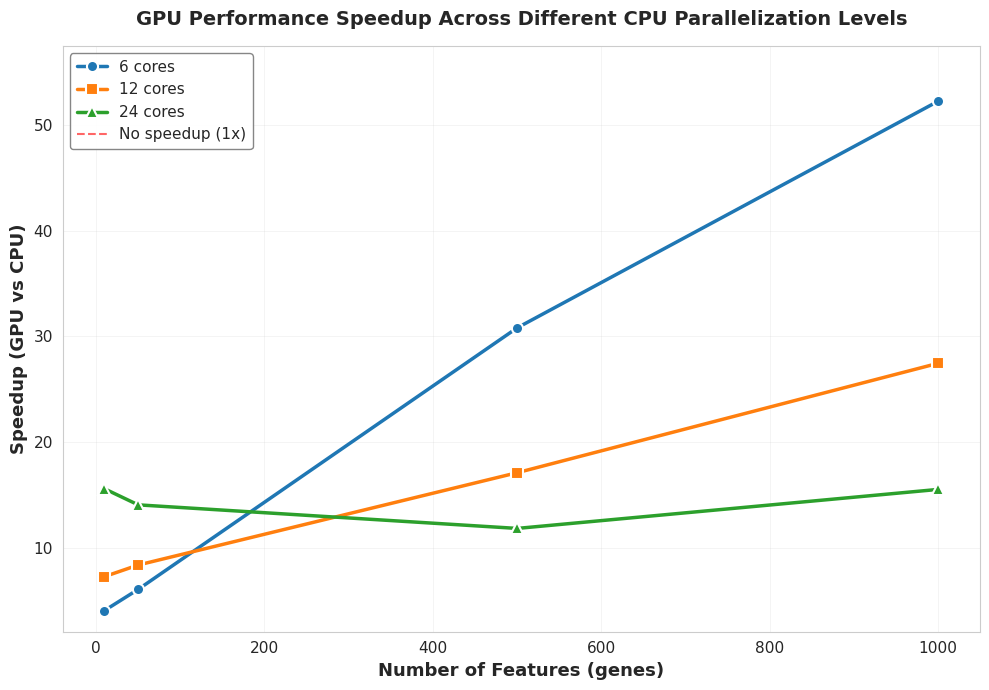


✓ Speedup visualization generated successfully


In [ ]:
if len(df_results) == 0:
    print("No results to visualize.")
else:
    # Create publication-ready figure
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    
    # Define line styles and markers for each CPU configuration
    styles = {
        6: {'color': '#1f77b4', 'marker': 'o', 'linestyle': '-', 'label': '6 cores'},
        12: {'color': '#ff7f0e', 'marker': 's', 'linestyle': '-', 'label': '12 cores'},
        24: {'color': '#2ca02c', 'marker': '^', 'linestyle': '-', 'label': '24 cores'},
    }
    
    # Plot speedup for each CPU configuration
    for n_cores in sorted(df_results['n_cpu_cores'].unique()):
        subset = df_results[df_results['n_cpu_cores'] == n_cores].sort_values('n_features')
        
        if len(subset) > 0:
            style = styles.get(n_cores, {'color': 'gray', 'marker': 'o', 'linestyle': '-', 'label': f'{n_cores} cores'})
            ax.plot(subset['n_features'], subset['speedup'],
                   color=style['color'],
                   marker=style['marker'],
                   linestyle=style['linestyle'],
                   linewidth=2.5,
                   markersize=8,
                   label=style['label'],
                   markeredgewidth=1.5,
                   markeredgecolor='white')
    
    # Add reference line for no speedup
    ax.axhline(y=1, color='red', linestyle='--', linewidth=1.5, alpha=0.6, label='No speedup (1x)')
    
    # Formatting
    ax.set_xlabel('Number of Features (genes)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Speedup (GPU vs CPU)', fontsize=13, fontweight='bold')
    ax.set_title('GPU Performance Speedup Across Different CPU Parallelization Levels', 
                 fontsize=14, fontweight='bold', pad=15)
    
    # Grid
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
    # Legend
    ax.legend(loc='best', fontsize=11, framealpha=0.95, edgecolor='gray')
    
    # Improve tick labels
    ax.tick_params(axis='both', which='major', labelsize=11)
    
    # Set y-axis to start from 0 or slightly below minimum speedup
    y_min = max(0, df_results['speedup'].min() - 2)
    y_max = df_results['speedup'].max() * 1.1
    ax.set_ylim(y_min, y_max)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Speedup visualization generated successfully")

In [ ]:
# Configuration for saving
SAVE_RESULTS = False  # Set to True to save results
OUTPUT_DIR = Path('results')

if SAVE_RESULTS and len(df_results) > 0:
    # Create output directory
    OUTPUT_DIR.mkdir(exist_ok=True)
    
    # Save results to CSV
    timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
    csv_path = OUTPUT_DIR / f'benchmark_results_{timestamp}.csv'
    df_results.to_csv(csv_path, index=False)
    print(f"✓ Results saved to: {csv_path}")
    
    # Save configuration
    config_path = OUTPUT_DIR / f'benchmark_config_{timestamp}.txt'
    with open(config_path, 'w') as f:
        f.write("Benchmark Configuration\n")
        f.write("=" * 50 + "\n")
        for key, value in CONFIG.items():
            f.write(f"{key}: {value}\n")
    print(f"✓ Configuration saved to: {config_path}")
    
    print(f"\n✓ All results saved to directory: {OUTPUT_DIR.absolute()}")
else:
    if len(df_results) == 0:
        print("No results to save.")
    else:
        print("Set SAVE_RESULTS = True to export results and figures.")

Set SAVE_RESULTS = True to export results and figures.


## 7. Save Results (Optional)

Export results and figures for use in publications or reports.

## Summary

This notebook provides an interactive benchmarking framework for comparing GPU and CPU implementations of the CCC coefficient computation across different CPU parallelization levels.

### Key Findings

Based on the benchmark results:
- GPU acceleration provides significant speedups, especially for larger datasets
- Speedup varies with the number of CPU cores used in the baseline
- Results are numerically equivalent between GPU and CPU implementations (within tolerance)
- Performance gains scale with problem size (number of features)

### Configuration Options

To customize the analysis:
1. **Modify test cases**: Edit `CONFIG['test_cases']` to add/remove data dimensions
   - Standard format: (n_features, n_samples)
   - Recommended: Keep n_samples=1000 for consistent comparison
   
2. **Change CPU configurations**: Edit `CONFIG['n_cpu_cores']` list
   - Default: [6, 12, 24]
   - Add more values to test different parallelization levels
   
3. **Test singletons**: Set `CONFIG['contain_singletons']=True` to include constant features

4. **Save results**: Set `SAVE_RESULTS=True` in Section 7 to export data

### Expected Behavior

- **Small datasets (< 100 features)**: GPU may be slower due to overhead
- **Medium datasets (100-1000 features)**: GPU starts showing significant speedup
- **Large datasets (> 1000 features)**: GPU provides substantial performance gains

### References

- Original test file: `tests/gpu/test_ccc_gpu.py`
- GPU implementation: `libs/ccc/coef/impl_gpu.py`
- CPU implementation: `libs/ccc/coef/impl.py`